1. <a href='#1'>  СОЗДАНИЕ ОТЧЕТА SALES REPORT BY MONTH </a>
2. <a href='#2'>  ПОСТРОЕНИЕ CHURN REPORT </a>
3. <a href='#3'>  КОГОРТНЫЙ АНАЛИЗ </a>
4. <a href='#4'> СОЗДАНИЕ RFM МОДЕЛИ </a>




### 1. СОЗДАНИЕ ОТЧЕТА SALES REPORT BY MONTH <a id='1'></a>




In [1]:
!wget https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release -O sqlite.tar.gz
!tar xzf sqlite.tar.gz
%cd sqlite/
!./configure
!make sqlite3.c
%cd /content
!npx degit coleifer/pysqlite3 -f
!cp sqlite/sqlite3.[ch] .
!python setup.py build_static build
!cp build/lib.linux-x86_64-3.6/pysqlite3/_sqlite3.cpython-36m-x86_64-linux-gnu.so \
    /usr/lib/python3.6/lib-dynload/_sqlite3.cpython-36m-x86_64-linux-gnu.so

--2020-10-15 16:38:49--  https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release
Resolving www.sqlite.org (www.sqlite.org)... 45.33.6.223, 2600:3c00::f03c:91ff:fe96:b959
Connecting to www.sqlite.org (www.sqlite.org)|45.33.6.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11075165 (11M) [application/x-compressed]
Saving to: ‘sqlite.tar.gz’

sqlite.tar.gz       100%[===================>]  10.56M  6.54MB/s    in 1.6s    

2020-10-15 16:38:54 (6.54 MB/s) - ‘sqlite.tar.gz’ saved [11075165/11075165]

/content/sqlite
checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
chec

In [3]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import sqlite3
conn = sqlite3.connect('example.db')
cur = conn.cursor()

In [2]:
sqlite3.sqlite_version

'3.33.0'

In [4]:
df = pd.read_csv('/content/drive/My Drive/data/e_commerce_data.csv', encoding= 'unicode_escape')

In [5]:
df.sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
79348,542931,22784,LANTERN CREAM GAZEBO,3,2/2/2011 10:46,4.95,15589.0,United Kingdom
3447,536630,21871,SAVE THE PLANET MUG,6,12/2/2010 10:56,1.06,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [10]:
df.columns = df.columns.str.lower()

In [11]:
df['invoicedate'] = pd.to_datetime(df['invoicedate'], format="%m/%d/%Y %H:%M")

In [12]:
df.to_sql('sales', conn, index=False, if_exists='replace')

In [13]:
sql = ''' select * from sales limit 10'''

In [14]:
pd.read_sql(sql,conn)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [15]:
def select(sql):
  return pd.read_sql(sql,conn)

In [16]:
select(sql)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


Найдем первую дату покупки для каждого id - назовем ее как дату регистрации

In [17]:
sql = ''' select customerid, min(invoicedate) as reg_date from sales
group by customerid limit 5'''

In [18]:
select(sql)

,customerid,reg_date
0,12346.0,2011-01-18 10:01:00
1,12347.0,2010-12-07 14:57:00
2,12348.0,2010-12-16 19:09:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


Уберем пропущенные значения id

In [19]:
sql = ''' select t.customerid, min(t.invoicedate) as reg_date from sales t
where t.customerid is not null
group by t.customerid limit 5'''

In [20]:
select(sql)

,customerid,reg_date
0,12346.0,2011-01-18 10:01:00
1,12347.0,2010-12-07 14:57:00
2,12348.0,2010-12-16 19:09:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


Отберем из даты регистрации только месяц и назовем столбец как reg_month
и создадим как новую таблицу users
min(date_trunc('month', t.invoicedate)) as reg_month - в postgresql

In [21]:
sql = ''' 
drop table if exists users;
create table users as 
select t.customerid, min(date(t.invoicedate, 'start of month')) as reg_month from sales t
where t.customerid is not null
group by t.customerid

'''

In [22]:
cur.executescript(sql)

In [23]:
sql = '''select count(*) from users ''' # кол-во уникальных покупателей в нашей таблице

In [24]:
select(sql)

,count(*)
0,4372


In [25]:
sql = '''select * from users limit 5'''

In [26]:
select(sql)

,customerid,reg_month
0,12346.0,2011-01-01
1,12347.0,2010-12-01
2,12348.0,2010-12-01
3,12349.0,2011-11-01
4,12350.0,2011-02-01


Создадим date range для рыбы

In [27]:
 sql = '''

WITH RECURSIVE dates(date) AS (
  VALUES('2000-10-03')
  UNION ALL
  SELECT date(date, '+1 day')
  FROM dates
  WHERE date < '2020-31-12'
)
select * from dates
 '''

In [28]:
select(sql)

,date
0,2000-10-03
1,2000-10-04
2,2000-10-05
3,2000-10-06
4,2000-10-07
...,...
7391,2020-12-28
7392,2020-12-29
7393,2020-12-30
7394,2020-12-31


In [29]:
sql = ''' select * from sales limit 3 '''

In [30]:
select(sql)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [31]:
sql = '''
drop table if exists asd;
create table asd as 

WITH RECURSIVE dates(date) AS (
  VALUES('2000-10-03')
  UNION ALL
  SELECT date(date, '+1 day')
  FROM dates
  WHERE date < '2020-31-12'
)
SELECT distinct date(d.date, 'start of month') as month FROM dates d
where d.date between (select min(date(t.invoicedate, 'start of month')) from sales t )
and (select max(date(t.invoicedate, 'start of month')) from sales t )

'''

In [32]:
cur.executescript(sql)

In [33]:
sql = '''select * from asd '''

In [34]:
select(sql)

,month
0,2010-12-01
1,2011-01-01
2,2011-02-01
3,2011-03-01
4,2011-04-01
5,2011-05-01
6,2011-06-01
7,2011-07-01
8,2011-08-01
9,2011-09-01


In [35]:
4372 * 13 # число строк должно быть в новой таблице

56836

In [36]:
sql ='''select * from users u
join asd on asd.month>=u.reg_month 
limit 5'''

In [37]:
select(sql)

,customerid,reg_month,month
0,12346.0,2011-01-01,2011-01-01
1,12346.0,2011-01-01,2011-02-01
2,12346.0,2011-01-01,2011-03-01
3,12346.0,2011-01-01,2011-04-01
4,12346.0,2011-01-01,2011-05-01


In [38]:
sql = '''
drop table if exists user_month_1;
create table user_month_1 as 
select * from users u
join asd on asd.month>=u.reg_month
'''

In [39]:
cur.executescript(sql)

In [40]:
sql = '''select count(*) from user_month_1'''

In [41]:
select(sql)

,count(*)
0,37436


< чем 4372 * 13 = 56836, т.к. отсеили данные, где у id дата регистрации позже, чем месяц покупки

In [42]:
sql = '''select * from user_month_1
limit 10'''

In [43]:
select(sql)

,customerid,reg_month,month
0,12346.0,2011-01-01,2011-01-01
1,12346.0,2011-01-01,2011-02-01
2,12346.0,2011-01-01,2011-03-01
3,12346.0,2011-01-01,2011-04-01
4,12346.0,2011-01-01,2011-05-01
5,12346.0,2011-01-01,2011-06-01
6,12346.0,2011-01-01,2011-07-01
7,12346.0,2011-01-01,2011-08-01
8,12346.0,2011-01-01,2011-09-01
9,12346.0,2011-01-01,2011-10-01


In [44]:
sql = '''
select t.customerid, date(t.invoicedate, 'start of month') as month,
count(*)
from sales t
group by t.customerid, date(t.invoicedate, 'start of month')
limit 5
'''

In [45]:
select(sql)

,customerid,month,count(*)
0,12346.0,2011-01-01,2
1,12347.0,2010-12-01,31
2,12347.0,2011-01-01,29
3,12347.0,2011-04-01,24
4,12347.0,2011-06-01,18


In [46]:
sql = '''
select *
from sales t limit 5
'''

In [47]:
select(sql)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [48]:
sql = '''
select t.customerid, date(t.invoicedate, 'start of month') as month,
count(*)
from sales t
where t.customerid=12347.0
group by t.customerid, date(t.invoicedate, 'start of month')
order by date(t.invoicedate, 'start of month')
'''
# проверка на 1 id

In [49]:
select(sql)

,customerid,month,count(*)
0,12347.0,2010-12-01,31
1,12347.0,2011-01-01,29
2,12347.0,2011-04-01,24
3,12347.0,2011-06-01,18
4,12347.0,2011-08-01,22
5,12347.0,2011-10-01,47
6,12347.0,2011-12-01,11


In [50]:
sql = '''
drop table if exists sales_month_agg;
create table sales_month_agg as
select t.customerid, date(t.invoicedate, 'start of month') as month,
count(*) as trans_cnt,
count(distinct t.invoiceno) as invoice_cnt,
sum(t.unitprice*t.quantity) as revenue
from sales t

group by t.customerid, date(t.invoicedate, 'start of month')
order by date(t.invoicedate, 'start of month')
'''
# группируем для каждого id число покупок, выручку

In [51]:
cur.executescript(sql)

In [52]:
sql = ''' select * from sales_month_agg limit 7 '''

In [53]:
select(sql)

,customerid,month,trans_cnt,invoice_cnt,revenue
0,12347.0,2010-12-01,31,1,711.79
1,12348.0,2010-12-01,17,1,892.80
2,12370.0,2010-12-01,91,2,1868.02
3,12377.0,2010-12-01,43,1,1001.52
4,12383.0,2010-12-01,37,1,600.72
5,12386.0,2010-12-01,8,1,258.90
6,12395.0,2010-12-01,31,2,679.92


In [54]:
sql = ''' 
select 
t.*, s.invoice_cnt, s.revenue
from user_month_1 t
left join sales_month_agg s
on t.customerid = s.customerid and t.month = s.month
limit 10
'''
# джойним рыбу и сгруппированную таблицу

In [55]:
select(sql)

,customerid,reg_month,month,invoice_cnt,revenue
0,12346.0,2011-01-01,2011-01-01,2.0,0.0
1,12346.0,2011-01-01,2011-02-01,NaN,NaN
2,12346.0,2011-01-01,2011-03-01,NaN,NaN
3,12346.0,2011-01-01,2011-04-01,NaN,NaN
4,12346.0,2011-01-01,2011-05-01,NaN,NaN
5,12346.0,2011-01-01,2011-06-01,NaN,NaN
6,12346.0,2011-01-01,2011-07-01,NaN,NaN
7,12346.0,2011-01-01,2011-08-01,NaN,NaN
8,12346.0,2011-01-01,2011-09-01,NaN,NaN
9,12346.0,2011-01-01,2011-10-01,NaN,NaN


In [56]:
sql = ''' 
drop table if exists sales_month;
create table sales_month as 
select 
t.*, s.invoice_cnt, s.revenue,
1 as customer,
case when s.invoice_cnt > 0 then 1 else 0 end as active 
from user_month_1 t
left join sales_month_agg s
on t.customerid = s.customerid and t.month = s.month
'''
# создаем новую таблицу

In [57]:
cur.executescript(sql)

In [58]:
sql = '''select * from sales_month limit 5'''

In [59]:
select(sql)

,customerid,reg_month,month,invoice_cnt,revenue,customer,active
0,12346.0,2011-01-01,2011-01-01,2.0,0.0,1,1
1,12346.0,2011-01-01,2011-02-01,NaN,NaN,1,0
2,12346.0,2011-01-01,2011-03-01,NaN,NaN,1,0
3,12346.0,2011-01-01,2011-04-01,NaN,NaN,1,0
4,12346.0,2011-01-01,2011-05-01,NaN,NaN,1,0


In [60]:
sql = '''select * from sales_month t
where t.customerid = 12347
'''
# проверка на 1м клиенте

In [61]:
select(sql)

,customerid,reg_month,month,invoice_cnt,revenue,customer,active
0,12347.0,2010-12-01,2010-12-01,1.0,711.79,1,1
1,12347.0,2010-12-01,2011-01-01,1.0,475.39,1,1
2,12347.0,2010-12-01,2011-02-01,NaN,NaN,1,0
3,12347.0,2010-12-01,2011-03-01,NaN,NaN,1,0
4,12347.0,2010-12-01,2011-04-01,1.0,636.25,1,1
5,12347.0,2010-12-01,2011-05-01,NaN,NaN,1,0
6,12347.0,2010-12-01,2011-06-01,1.0,382.52,1,1
7,12347.0,2010-12-01,2011-07-01,NaN,NaN,1,0
8,12347.0,2010-12-01,2011-08-01,1.0,584.91,1,1
9,12347.0,2010-12-01,2011-09-01,NaN,NaN,1,0


In [62]:
sql = '''
select t.month, count(distinct t.customerid), count(*) from sales_month t
group by t.month
'''
# проверка на дубликаты - цифры равны,значит дублей нет

In [63]:
select(sql)

,month,count(distinct t.customerid),count(*)
0,2010-12-01,948,948
1,2011-01-01,1369,1369
2,2011-02-01,1749,1749
3,2011-03-01,2189,2189
4,2011-04-01,2488,2488
5,2011-05-01,2767,2767
6,2011-06-01,3002,3002
7,2011-07-01,3193,3193
8,2011-08-01,3360,3360
9,2011-09-01,3658,3658


In [64]:
sql= '''
select 
t.month, sum(t.customer) as customer, sum(t.invoice_cnt) as invoice,
sum(t.revenue) as revenue,
sum(t.active) as active,
1.0 * sum(t.active)  / sum(t.customer) as active_pct
from sales_month t 
group by t.month
'''

In [65]:
select(sql)

,month,customer,invoice,revenue,active,active_pct
0,2010-12-01,948,1708,554604.020,948,1.000000
1,2011-01-01,1369,1236,475074.380,783,0.571950
2,2011-02-01,1749,1202,436546.150,798,0.456261
3,2011-03-01,2189,1619,579964.610,1020,0.465966
4,2011-04-01,2488,1384,426047.851,899,0.361334
5,2011-05-01,2767,1849,648251.080,1079,0.389953
6,2011-06-01,3002,1707,608013.160,1051,0.350100
7,2011-07-01,3193,1593,574238.481,993,0.310993
8,2011-08-01,3360,1544,616368.000,980,0.291667
9,2011-09-01,3658,2078,931440.372,1302,0.355932


In [66]:
df_new = select(sql)

In [67]:
df_new

,month,customer,invoice,revenue,active,active_pct
0,2010-12-01,948,1708,554604.020,948,1.000000
1,2011-01-01,1369,1236,475074.380,783,0.571950
2,2011-02-01,1749,1202,436546.150,798,0.456261
3,2011-03-01,2189,1619,579964.610,1020,0.465966
4,2011-04-01,2488,1384,426047.851,899,0.361334
5,2011-05-01,2767,1849,648251.080,1079,0.389953
6,2011-06-01,3002,1707,608013.160,1051,0.350100
7,2011-07-01,3193,1593,574238.481,993,0.310993
8,2011-08-01,3360,1544,616368.000,980,0.291667
9,2011-09-01,3658,2078,931440.372,1302,0.355932


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

Text(0.5, 1.0, 'Active percentage')

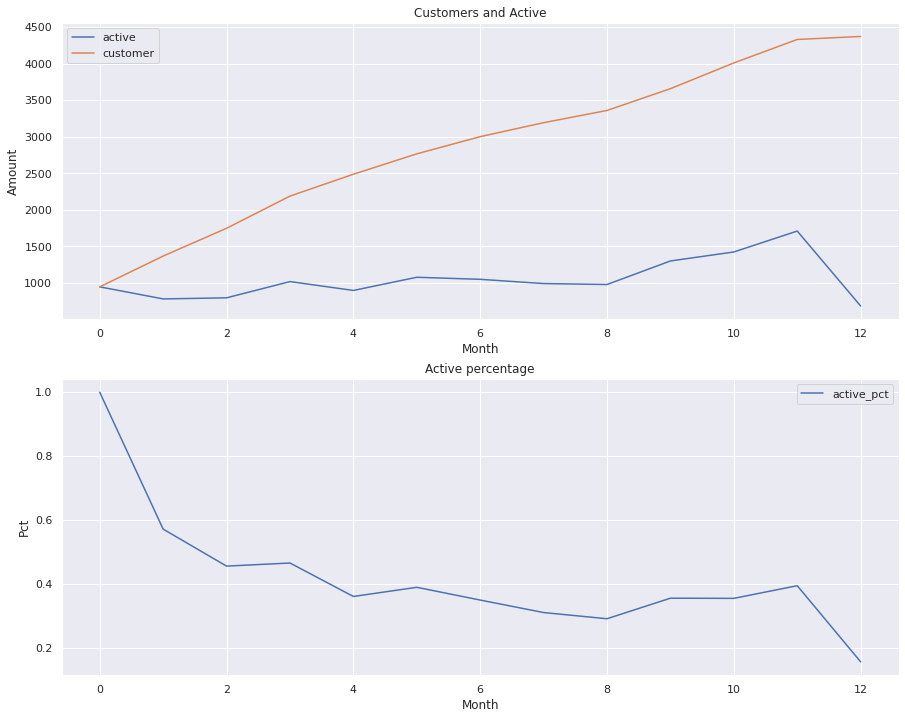

In [69]:
fig = plt.figure(figsize=(40,40))
ax1 = fig.add_subplot(2,1,1)
df_new.plot(ax=ax1,y = ['active', 'customer'], grid=True, figsize=(15,7))

ax1.set_xlabel('Month')
ax1.set_ylabel('Amount')
ax1.set_title('Customers and Active')

ax2 = fig.add_subplot(2,1,2)
df_new.plot(ax=ax2,y = 'active_pct', grid=True, figsize=(15,12))
ax2.set_xlabel('Month')
ax2.set_ylabel('Pct')
ax2.set_title('Active percentage')
# визуализация динамика кумулятивных покупателей\активных в месяц продаж\доля активных

Рост активных покупателей под конец года - под НГ

### 2. ПОСТРОЕНИЕ CHURN REPORT <a id='2'></a>

In [70]:
sql = ''' 
drop table if exists sales_month_churn;
create table sales_month_churn as
select 
t.*, 
s.invoice_cnt, 
s.revenue,
1 as customer,
case when s.invoice_cnt > 0 then 1 else 0 end as active,
max(case when s.invoice_cnt > 0 then t.month else null end) over (partition by t.customerid order by t.month) as last_month
from user_month_1 t
left join sales_month_agg s
on t.customerid = s.customerid and t.month = s.month
'''
# находим через оконную ф-ю последний месяц покупки для каждого месяца

In [71]:
cur.executescript(sql)

In [72]:
sql= '''
select 
*
from sales_month_churn t 
where t.customerid = 12347
'''

In [73]:
select(sql)

,customerid,reg_month,month,invoice_cnt,revenue,customer,active,last_month
0,12347.0,2010-12-01,2010-12-01,1.0,711.79,1,1,2010-12-01
1,12347.0,2010-12-01,2011-01-01,1.0,475.39,1,1,2011-01-01
2,12347.0,2010-12-01,2011-02-01,NaN,NaN,1,0,2011-01-01
3,12347.0,2010-12-01,2011-03-01,NaN,NaN,1,0,2011-01-01
4,12347.0,2010-12-01,2011-04-01,1.0,636.25,1,1,2011-04-01
5,12347.0,2010-12-01,2011-05-01,NaN,NaN,1,0,2011-04-01
6,12347.0,2010-12-01,2011-06-01,1.0,382.52,1,1,2011-06-01
7,12347.0,2010-12-01,2011-07-01,NaN,NaN,1,0,2011-06-01
8,12347.0,2010-12-01,2011-08-01,1.0,584.91,1,1,2011-08-01
9,12347.0,2010-12-01,2011-09-01,NaN,NaN,1,0,2011-08-01


In [74]:
sql = ''' 
drop table if exists sales_month;
create table sales_month as
select 
t.*, 
s.invoice_cnt, 
s.revenue,
1 as customer,
case when s.invoice_cnt > 0 then 1 else 0 end as active,
max(case when s.invoice_cnt > 0 then t.month else null end) over (partition by t.customerid order by t.month) as last_month,


strftime('%m', t.month) - strftime('%m',max(case when s.invoice_cnt > 0 then t.month else null end) 
over (partition by t.customerid order by t.month)) + strftime('%Y', t.month)*12 - strftime('%Y',max(case when s.invoice_cnt > 0 then t.month else null end) 
over (partition by t.customerid order by t.month))*12 as last_order_cnt


from user_month_1 t
left join sales_month_agg s
on t.customerid = s.customerid and t.month = s.month
'''
# находим разницу  в месяцах между датой и последней датой покупки для каждого id

в Postgresql будет так <br/>
extract(year from age(t.monthmax(case when s.invoice_cnt > 0 then t.month else null end) over (partition by t.customerid order by t.month), timestamp2)) * 12 +
extract(month from age(t.month, max(case when s.invoice_cnt > 0 then t.month else null end) over (partition by t.customerid order by t.month)))

In [75]:
cur.executescript(sql)

In [76]:
sql= '''
select 
*
from sales_month t 
where t.customerid = 12347
'''

In [77]:
select(sql)

,customerid,reg_month,month,invoice_cnt,revenue,customer,active,last_month,last_order_cnt
0,12347.0,2010-12-01,2010-12-01,1.0,711.79,1,1,2010-12-01,0
1,12347.0,2010-12-01,2011-01-01,1.0,475.39,1,1,2011-01-01,0
2,12347.0,2010-12-01,2011-02-01,NaN,NaN,1,0,2011-01-01,1
3,12347.0,2010-12-01,2011-03-01,NaN,NaN,1,0,2011-01-01,2
4,12347.0,2010-12-01,2011-04-01,1.0,636.25,1,1,2011-04-01,0
5,12347.0,2010-12-01,2011-05-01,NaN,NaN,1,0,2011-04-01,1
6,12347.0,2010-12-01,2011-06-01,1.0,382.52,1,1,2011-06-01,0
7,12347.0,2010-12-01,2011-07-01,NaN,NaN,1,0,2011-06-01,1
8,12347.0,2010-12-01,2011-08-01,1.0,584.91,1,1,2011-08-01,0
9,12347.0,2010-12-01,2011-09-01,NaN,NaN,1,0,2011-08-01,1


In [78]:
sql= '''
select 
t.month, sum(t.customer) as customer, sum(t.invoice_cnt) as invoice,
sum(t.revenue) as revenue,
sum(t.active) as active,
1.0 * sum(t.active)  / sum(t.customer) as active_pct,
sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt
from sales_month t 
group by t.month
'''
# сколько id не покупают >= 2 месяцев подряд

In [79]:
select(sql)

,month,customer,invoice,revenue,active,active_pct,churn_2mnt_cnt
0,2010-12-01,948,1708,554604.020,948,1.000000,0
1,2011-01-01,1369,1236,475074.380,783,0.571950,0
2,2011-02-01,1749,1202,436546.150,798,0.456261,467
3,2011-03-01,2189,1619,579964.610,1020,0.465966,716
4,2011-04-01,2488,1384,426047.851,899,0.361334,915
5,2011-05-01,2767,1849,648251.080,1079,0.389953,1188
6,2011-06-01,3002,1707,608013.160,1051,0.350100,1336
7,2011-07-01,3193,1593,574238.481,993,0.310993,1564
8,2011-08-01,3360,1544,616368.000,980,0.291667,1820
9,2011-09-01,3658,2078,931440.372,1302,0.355932,1841


In [80]:
for i in range(2,6):
  print(f'sum(case when t.last_order_cnt >= {i} then 1 else 0 end) as churn_{i}mnt_cnt,')

sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end) as churn_3mnt_cnt,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end) as churn_4mnt_cnt,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end) as churn_5mnt_cnt,


In [81]:
sql= '''
select 
t.month, sum(t.customer) as customer, sum(t.invoice_cnt) as invoice,
sum(t.revenue) as revenue,
sum(t.active) as active,
1.0 * sum(t.active)  / sum(t.customer) as active_pct,
sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end) as churn_3mnt_cnt,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end) as churn_4mnt_cnt,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end) as churn_5mnt_cnt
from sales_month t 
group by t.month
'''
# меняем ширину churn month

In [82]:
select(sql)

,month,customer,invoice,revenue,active,active_pct,churn_2mnt_cnt,churn_3mnt_cnt,churn_4mnt_cnt,churn_5mnt_cnt
0,2010-12-01,948,1708,554604.020,948,1.000000,0,0,0,0
1,2011-01-01,1369,1236,475074.380,783,0.571950,0,0,0,0
2,2011-02-01,1749,1202,436546.150,798,0.456261,467,0,0,0
3,2011-03-01,2189,1619,579964.610,1020,0.465966,716,377,0,0
4,2011-04-01,2488,1384,426047.851,899,0.361334,915,582,316,0
5,2011-05-01,2767,1849,648251.080,1079,0.389953,1188,740,491,278
6,2011-06-01,3002,1707,608013.160,1051,0.350100,1336,978,631,426
7,2011-07-01,3193,1593,574238.481,993,0.310993,1564,1129,852,559
8,2011-08-01,3360,1544,616368.000,980,0.291667,1820,1367,1022,781
9,2011-09-01,3658,2078,931440.372,1302,0.355932,1841,1462,1141,879


In [83]:
sql= '''
select 
t.month, sum(t.customer) as customer, sum(t.invoice_cnt) as invoice,
sum(t.revenue) as revenue,
sum(t.active) as active,
1.0 * sum(t.active)  / sum(t.customer) as active_pct,

lag(sum(t.customer),1) over (order by t.month) as prev_customer,

sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end) as churn_3mnt_cnt,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end) as churn_4mnt_cnt,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end) as churn_5mnt_cnt
from sales_month t 
group by t.month
'''
# находим число покупателей предыдущего месяца

In [84]:
select(sql)

,month,customer,invoice,revenue,active,active_pct,prev_customer,churn_2mnt_cnt,churn_3mnt_cnt,churn_4mnt_cnt,churn_5mnt_cnt
0,2010-12-01,948,1708,554604.020,948,1.000000,NaN,0,0,0,0
1,2011-01-01,1369,1236,475074.380,783,0.571950,948.0,0,0,0,0
2,2011-02-01,1749,1202,436546.150,798,0.456261,1369.0,467,0,0,0
3,2011-03-01,2189,1619,579964.610,1020,0.465966,1749.0,716,377,0,0
4,2011-04-01,2488,1384,426047.851,899,0.361334,2189.0,915,582,316,0
5,2011-05-01,2767,1849,648251.080,1079,0.389953,2488.0,1188,740,491,278
6,2011-06-01,3002,1707,608013.160,1051,0.350100,2767.0,1336,978,631,426
7,2011-07-01,3193,1593,574238.481,993,0.310993,3002.0,1564,1129,852,559
8,2011-08-01,3360,1544,616368.000,980,0.291667,3193.0,1820,1367,1022,781
9,2011-09-01,3658,2078,931440.372,1302,0.355932,3360.0,1841,1462,1141,879


In [85]:
for i in range(2,6):
  print(f'sum(case when t.last_order_cnt >= {i} then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_{i}mnth_pct,')

sum(case when t.last_order_cnt >= 2 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_2mnth_pct,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_3mnth_pct,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_4mnth_pct,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_5mnth_pct,


In [86]:
sql= '''
drop table if exists sales_month_churn;
create  table sales_month_churn as
select 
t.month, sum(t.customer) as customer, sum(t.invoice_cnt) as invoice,
sum(t.revenue) as revenue,
sum(t.active) as active,
1.0 * sum(t.active)  / sum(t.customer) as active_pct,

lag(sum(t.customer),1) over (order by t.month) as prev_customer,

sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end) as churn_3mnt_cnt,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end) as churn_4mnt_cnt,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end) as churn_5mnt_cnt,


sum(case when t.last_order_cnt >= 2 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_2mnth_pct,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_3mnth_pct,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_4mnth_pct,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_5mnth_pct


from sales_month t 
group by t.month
'''
# находим число покупателей предыдущего месяца

In [87]:
cur.executescript(sql)

In [88]:
sql = '''select * from sales_month_churn '''

In [89]:
select(sql)

,month,customer,invoice,revenue,active,active_pct,prev_customer,churn_2mnt_cnt,churn_3mnt_cnt,churn_4mnt_cnt,churn_5mnt_cnt,churn_2mnth_pct,churn_3mnth_pct,churn_4mnth_pct,churn_5mnth_pct
0,2010-12-01,948,1708,554604.020,948,1.000000,NaN,0,0,0,0,NaN,NaN,NaN,NaN
1,2011-01-01,1369,1236,475074.380,783,0.571950,948.0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
2,2011-02-01,1749,1202,436546.150,798,0.456261,1369.0,467,0,0,0,0.341125,0.000000,0.000000,0.000000
3,2011-03-01,2189,1619,579964.610,1020,0.465966,1749.0,716,377,0,0,0.409377,0.215552,0.000000,0.000000
4,2011-04-01,2488,1384,426047.851,899,0.361334,2189.0,915,582,316,0,0.417999,0.265875,0.144358,0.000000
5,2011-05-01,2767,1849,648251.080,1079,0.389953,2488.0,1188,740,491,278,0.477492,0.297428,0.197347,0.111736
6,2011-06-01,3002,1707,608013.160,1051,0.350100,2767.0,1336,978,631,426,0.482833,0.353451,0.228045,0.153957
7,2011-07-01,3193,1593,574238.481,993,0.310993,3002.0,1564,1129,852,559,0.520986,0.376083,0.283811,0.186209
8,2011-08-01,3360,1544,616368.000,980,0.291667,3193.0,1820,1367,1022,781,0.569997,0.428124,0.320075,0.244598
9,2011-09-01,3658,2078,931440.372,1302,0.355932,3360.0,1841,1462,1141,879,0.547917,0.435119,0.339583,0.261607


In [90]:
df_churn = select(sql)

In [91]:
df_churn.head()

,month,customer,invoice,revenue,active,active_pct,prev_customer,churn_2mnt_cnt,churn_3mnt_cnt,churn_4mnt_cnt,churn_5mnt_cnt,churn_2mnth_pct,churn_3mnth_pct,churn_4mnth_pct,churn_5mnth_pct
0,2010-12-01,948,1708,554604.020,948,1.000000,NaN,0,0,0,0,NaN,NaN,NaN,NaN
1,2011-01-01,1369,1236,475074.380,783,0.571950,948.0,0,0,0,0,0.000000,0.000000,0.000000,0.0
2,2011-02-01,1749,1202,436546.150,798,0.456261,1369.0,467,0,0,0,0.341125,0.000000,0.000000,0.0
3,2011-03-01,2189,1619,579964.610,1020,0.465966,1749.0,716,377,0,0,0.409377,0.215552,0.000000,0.0
4,2011-04-01,2488,1384,426047.851,899,0.361334,2189.0,915,582,316,0,0.417999,0.265875,0.144358,0.0


In [92]:
df_churn.columns

Index(['month', 'customer', 'invoice', 'revenue', 'active', 'active_pct',
       'prev_customer', 'churn_2mnt_cnt', 'churn_3mnt_cnt', 'churn_4mnt_cnt',
       'churn_5mnt_cnt', 'churn_2mnth_pct', 'churn_3mnth_pct',
       'churn_4mnth_pct', 'churn_5mnth_pct'],
      dtype='object')

Text(0, 0.5, 'Pct %')

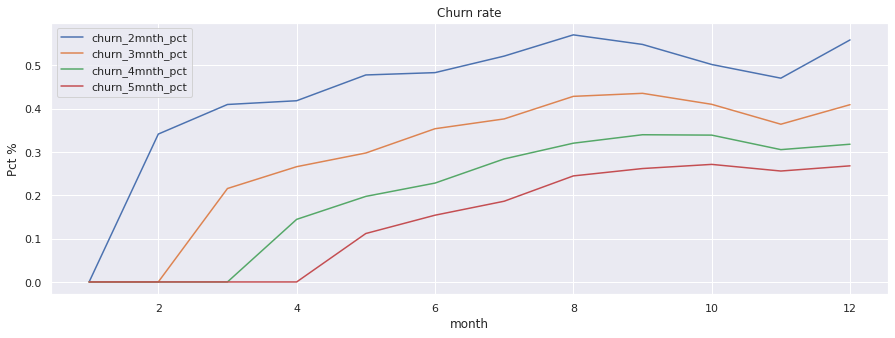

In [93]:
df_churn[['churn_2mnth_pct', 'churn_3mnth_pct',
       'churn_4mnth_pct', 'churn_5mnth_pct']].plot(figsize=(15,5))
       
plt.title('Churn rate')
plt.xlabel('month')
plt.ylabel('Pct %')

### 3. КОГОРТНЫЙ АНАЛИЗ <a id='3'></a>

In [94]:
sql = '''select * from sales_month t
where t.customerid = 12347
'''

In [95]:
select(sql)

,customerid,reg_month,month,invoice_cnt,revenue,customer,active,last_month,last_order_cnt
0,12347.0,2010-12-01,2010-12-01,1.0,711.79,1,1,2010-12-01,0
1,12347.0,2010-12-01,2011-01-01,1.0,475.39,1,1,2011-01-01,0
2,12347.0,2010-12-01,2011-02-01,NaN,NaN,1,0,2011-01-01,1
3,12347.0,2010-12-01,2011-03-01,NaN,NaN,1,0,2011-01-01,2
4,12347.0,2010-12-01,2011-04-01,1.0,636.25,1,1,2011-04-01,0
5,12347.0,2010-12-01,2011-05-01,NaN,NaN,1,0,2011-04-01,1
6,12347.0,2010-12-01,2011-06-01,1.0,382.52,1,1,2011-06-01,0
7,12347.0,2010-12-01,2011-07-01,NaN,NaN,1,0,2011-06-01,1
8,12347.0,2010-12-01,2011-08-01,1.0,584.91,1,1,2011-08-01,0
9,12347.0,2010-12-01,2011-09-01,NaN,NaN,1,0,2011-08-01,1


In [96]:
sql = ''' 
drop table if exists sales_month;
create table sales_month as
select 
t.*, 
s.invoice_cnt, 
s.revenue,
1 as customer,
case when t.reg_month = t.month then 1 else 0 end as new,
case when s.invoice_cnt > 0 then 1 else 0 end as active,
max(case when s.invoice_cnt > 0 then t.month else null end) over (partition by t.customerid order by t.month) as last_month,


strftime('%m', t.month) - strftime('%m',max(case when s.invoice_cnt > 0 then t.month else null end) 
over (partition by t.customerid order by t.month)) + strftime('%Y', t.month)*12 - strftime('%Y',max(case when s.invoice_cnt > 0 then t.month else null end) 
over (partition by t.customerid order by t.month))*12 as last_order_cnt


from user_month_1 t
left join sales_month_agg s
on t.customerid = s.customerid and t.month = s.month
'''
# находим число новых покупателей as new

In [97]:
cur.executescript(sql)

In [98]:
sql = '''select * from sales_month
where customerid = 12347
'''

In [99]:
select(sql)

,customerid,reg_month,month,invoice_cnt,revenue,customer,new,active,last_month,last_order_cnt
0,12347.0,2010-12-01,2010-12-01,1.0,711.79,1,1,1,2010-12-01,0
1,12347.0,2010-12-01,2011-01-01,1.0,475.39,1,0,1,2011-01-01,0
2,12347.0,2010-12-01,2011-02-01,NaN,NaN,1,0,0,2011-01-01,1
3,12347.0,2010-12-01,2011-03-01,NaN,NaN,1,0,0,2011-01-01,2
4,12347.0,2010-12-01,2011-04-01,1.0,636.25,1,0,1,2011-04-01,0
5,12347.0,2010-12-01,2011-05-01,NaN,NaN,1,0,0,2011-04-01,1
6,12347.0,2010-12-01,2011-06-01,1.0,382.52,1,0,1,2011-06-01,0
7,12347.0,2010-12-01,2011-07-01,NaN,NaN,1,0,0,2011-06-01,1
8,12347.0,2010-12-01,2011-08-01,1.0,584.91,1,0,1,2011-08-01,0
9,12347.0,2010-12-01,2011-09-01,NaN,NaN,1,0,0,2011-08-01,1


In [100]:
sql= '''
drop table if exists sales_month_churn;
create  table sales_month_churn as
select 
t.month, sum(t.customer) as customer, sum(t.invoice_cnt) as invoice,
sum(t.revenue) as revenue,
sum(t.new) as new,
sum(t.active) as active,
1.0 * sum(t.active)  / sum(t.customer) as active_pct,

lag(sum(t.customer),1) over (order by t.month) as prev_customer,

sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end) as churn_3mnt_cnt,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end) as churn_4mnt_cnt,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end) as churn_5mnt_cnt,


sum(case when t.last_order_cnt >= 2 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_2mnth_pct,
sum(case when t.last_order_cnt >= 3 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_3mnth_pct,
sum(case when t.last_order_cnt >= 4 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_4mnth_pct,
sum(case when t.last_order_cnt >= 5 then 1 else 0 end)*1.0 / lag(sum(t.customer),1) over (order by t.month) as churn_5mnth_pct


from sales_month t 
group by t.month
'''

In [101]:
cur.executescript(sql)

In [102]:
sql = '''select * from sales_month_churn 
'''

In [103]:
select(sql)

,month,customer,invoice,revenue,new,active,active_pct,prev_customer,churn_2mnt_cnt,churn_3mnt_cnt,churn_4mnt_cnt,churn_5mnt_cnt,churn_2mnth_pct,churn_3mnth_pct,churn_4mnth_pct,churn_5mnth_pct
0,2010-12-01,948,1708,554604.020,948,948,1.000000,NaN,0,0,0,0,NaN,NaN,NaN,NaN
1,2011-01-01,1369,1236,475074.380,421,783,0.571950,948.0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
2,2011-02-01,1749,1202,436546.150,380,798,0.456261,1369.0,467,0,0,0,0.341125,0.000000,0.000000,0.000000
3,2011-03-01,2189,1619,579964.610,440,1020,0.465966,1749.0,716,377,0,0,0.409377,0.215552,0.000000,0.000000
4,2011-04-01,2488,1384,426047.851,299,899,0.361334,2189.0,915,582,316,0,0.417999,0.265875,0.144358,0.000000
5,2011-05-01,2767,1849,648251.080,279,1079,0.389953,2488.0,1188,740,491,278,0.477492,0.297428,0.197347,0.111736
6,2011-06-01,3002,1707,608013.160,235,1051,0.350100,2767.0,1336,978,631,426,0.482833,0.353451,0.228045,0.153957
7,2011-07-01,3193,1593,574238.481,191,993,0.310993,3002.0,1564,1129,852,559,0.520986,0.376083,0.283811,0.186209
8,2011-08-01,3360,1544,616368.000,167,980,0.291667,3193.0,1820,1367,1022,781,0.569997,0.428124,0.320075,0.244598
9,2011-09-01,3658,2078,931440.372,298,1302,0.355932,3360.0,1841,1462,1141,879,0.547917,0.435119,0.339583,0.261607


In [104]:
sql = ''' 
drop table if exists sales_month;
create table sales_month as
select 
t.*, 
s.invoice_cnt, 
s.revenue,
1 as customer,
case when t.reg_month = t.month then 1 else 0 end as new,
case when s.invoice_cnt > 0 then 1 else 0 end as active,
max(case when s.invoice_cnt > 0 then t.month else null end) over (partition by t.customerid order by t.month) as last_month,


strftime('%m', t.month) - strftime('%m',max(case when s.invoice_cnt > 0 then t.month else null end) 
over (partition by t.customerid order by t.month)) + strftime('%Y', t.month)*12 - strftime('%Y',max(case when s.invoice_cnt > 0 then t.month else null end) 
over (partition by t.customerid order by t.month))*12 as last_order_cnt,


strftime('%m', t.month) - strftime('%m', t.reg_month) + strftime('%Y', t.month)*12 - strftime('%Y', t.reg_month)*12 as lifetime



from user_month_1 t
left join sales_month_agg s
on t.customerid = s.customerid and t.month = s.month
'''
# находим lifetime

In [105]:
cur.executescript(sql)

In [106]:
sql = '''select * from sales_month 
where customerid = 12347
'''

In [107]:
select(sql)

,customerid,reg_month,month,invoice_cnt,revenue,customer,new,active,last_month,last_order_cnt,lifetime
0,12347.0,2010-12-01,2010-12-01,1.0,711.79,1,1,1,2010-12-01,0,0
1,12347.0,2010-12-01,2011-01-01,1.0,475.39,1,0,1,2011-01-01,0,1
2,12347.0,2010-12-01,2011-02-01,NaN,NaN,1,0,0,2011-01-01,1,2
3,12347.0,2010-12-01,2011-03-01,NaN,NaN,1,0,0,2011-01-01,2,3
4,12347.0,2010-12-01,2011-04-01,1.0,636.25,1,0,1,2011-04-01,0,4
5,12347.0,2010-12-01,2011-05-01,NaN,NaN,1,0,0,2011-04-01,1,5
6,12347.0,2010-12-01,2011-06-01,1.0,382.52,1,0,1,2011-06-01,0,6
7,12347.0,2010-12-01,2011-07-01,NaN,NaN,1,0,0,2011-06-01,1,7
8,12347.0,2010-12-01,2011-08-01,1.0,584.91,1,0,1,2011-08-01,0,8
9,12347.0,2010-12-01,2011-09-01,NaN,NaN,1,0,0,2011-08-01,1,9


In [108]:
sql= '''
drop table if exists sales_month_cohort;
create table sales_month_cohort as
select 
t.reg_month,
t.lifetime, sum(t.customer) as customer, sum(t.invoice_cnt) as invoice,
sum(t.revenue) as revenue,
sum(t.new) as new,
sum(t.active) as active,
1.0 * sum(t.active)  / sum(t.customer) as active_pct,

sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt

from sales_month t 
group by t.reg_month, t.lifetime
'''

In [109]:
cur.executescript(sql)

In [110]:
sql = '''select * from sales_month_cohort'''

In [111]:
select(sql)

,reg_month,lifetime,customer,invoice,revenue,new,active,active_pct,churn_2mnt_cnt
0,2010-12-01,0,948,1708,554604.02,948,948,1.000000,0
1,2010-12-01,1,948,689,271616.52,0,362,0.381857,0
2,2010-12-01,2,948,579,230856.22,0,317,0.334388,467
3,2010-12-01,3,948,753,302509.39,0,367,0.387131,466
4,2010-12-01,4,948,611,200927.98,0,341,0.359705,435
...,...,...,...,...,...,...,...,...,...
86,2011-10-01,1,352,167,39209.92,0,93,0.264205,0
87,2011-10-01,2,352,57,12279.46,0,46,0.130682,239
88,2011-11-01,0,321,425,134231.38,321,321,1.000000,0
89,2011-11-01,1,321,55,14847.53,0,43,0.133956,0


In [112]:
df_cohort = select(sql)

In [113]:
df_cohort.pivot_table(index='reg_month', columns='lifetime', values='active_pct', aggfunc='mean').round(2)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
reg_month,,,,,,,,,,,,,
2010-12-01,1.0,0.38,0.33,0.39,0.36,0.40,0.38,0.35,0.35,0.39,0.37,0.50,0.27
2011-01-01,1.0,0.24,0.28,0.24,0.33,0.30,0.26,0.26,0.31,0.35,0.37,0.15,NaN
2011-02-01,1.0,0.25,0.19,0.28,0.27,0.25,0.26,0.28,0.26,0.31,0.09,NaN,NaN
2011-03-01,1.0,0.19,0.25,0.22,0.23,0.18,0.26,0.24,0.29,0.09,NaN,NaN,NaN
2011-04-01,1.0,0.23,0.22,0.21,0.21,0.24,0.23,0.26,0.08,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.24,0.17,0.17,0.22,0.24,0.27,0.10,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.21,0.19,0.27,0.25,0.34,0.10,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.21,0.20,0.23,0.27,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.25,0.25,0.25,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


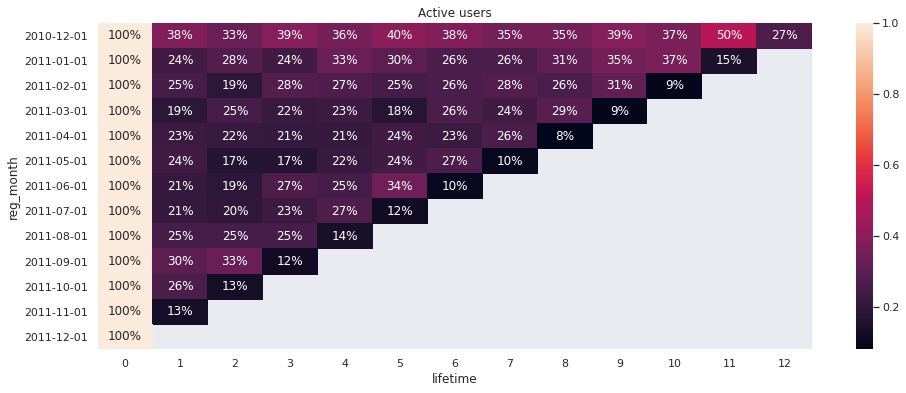

In [114]:
plt.figure(figsize=(16,6))
plt.title('Active users')
sns.heatmap(df_cohort.pivot_table(index='reg_month', columns='lifetime', values='active_pct', aggfunc='mean').round(2),
            annot=True,fmt='.0%')

In [115]:
df_cohort.pivot_table(index='reg_month', values='active_pct', aggfunc='mean').round(2)

,active_pct
reg_month,
2010-12-01,0.42
2011-01-01,0.34
2011-02-01,0.31
2011-03-01,0.30
2011-04-01,0.30
2011-05-01,0.30
2011-06-01,0.34
2011-07-01,0.34
2011-08-01,0.38


In [116]:
df_cohort.pivot_table(index='reg_month', values='active_pct', aggfunc='mean').round(2)

,active_pct
reg_month,
2010-12-01,0.42
2011-01-01,0.34
2011-02-01,0.31
2011-03-01,0.30
2011-04-01,0.30
2011-05-01,0.30
2011-06-01,0.34
2011-07-01,0.34
2011-08-01,0.38


In [117]:
df_cohort.pivot_table(index='lifetime', values='active_pct', aggfunc='mean').round(2)

,active_pct
lifetime,
0,1.00
1,0.24
2,0.23
3,0.24
4,0.25
5,0.26
6,0.25
7,0.25
8,0.26


In [118]:
sql= '''

select 
--t.reg_month,
t.lifetime,
 sum(t.customer) as customer, sum(t.invoice_cnt) as invoice,
sum(t.revenue) as revenue,
sum(t.new) as new,
sum(t.active) as active,
1.0 * sum(t.active)  / sum(t.customer) as active_pct,

sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt

from sales_month t 
group by --t.reg_month 
 t.lifetime
'''
# запрос без даты регистрации

In [119]:
select(sql)

,lifetime,customer,invoice,revenue,new,active,active_pct,churn_2mnt_cnt
0,0,4372,6067,2038421.353,4372,4372,1.000000,0
1,1,4331,1828,549732.670,0,1131,0.261141,0
2,2,4010,1607,538504.440,0,1003,0.250125,2393
3,3,3658,1622,571327.680,0,968,0.264625,2164
4,4,3360,1492,477574.050,0,938,0.279167,1916
5,5,3193,1584,583488.610,0,914,0.286251,1789
6,6,3002,1434,558951.800,0,850,0.283145,1682
7,7,2767,1345,538858.040,0,763,0.275750,1566
8,8,2488,1240,508770.721,0,717,0.288183,1401
9,9,2189,1268,642558.980,0,678,0.309730,1164


In [120]:
df_coh = select(sql)

In [121]:
df_coh.pivot_table(index='lifetime', values='active_pct', aggfunc='mean').round(2)
#  данные без группировки по дате регистрации

,active_pct
lifetime,
0,1.00
1,0.26
2,0.25
3,0.26
4,0.28
5,0.29
6,0.28
7,0.28
8,0.29


In [122]:
df_cohort.pivot_table(index='lifetime', values='active_pct', aggfunc='mean').round(2)
# данные с группировкой по дате регистрации, в каждой когорте разные кол-ва пользователей, поэтому разные цифры по lifetime

,active_pct
lifetime,
0,1.00
1,0.24
2,0.23
3,0.24
4,0.25
5,0.26
6,0.25
7,0.25
8,0.26


### 4. СОЗДАНИЕ RFM МОДЕЛИ <a id='4'></a>


In [123]:
sql= '''

select 
--t.reg_month,
t.lifetime,
 sum(t.customer) as customer, sum(t.invoice_cnt) as invoice,
sum(t.revenue) as revenue,
sum(t.new) as new,
sum(t.active) as active,
1.0 * sum(t.active)  / sum(t.customer) as active_pct,

sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt

from sales_month t 
group by --t.reg_month 
 t.lifetime
'''

In [124]:
select(sql)

,lifetime,customer,invoice,revenue,new,active,active_pct,churn_2mnt_cnt
0,0,4372,6067,2038421.353,4372,4372,1.000000,0
1,1,4331,1828,549732.670,0,1131,0.261141,0
2,2,4010,1607,538504.440,0,1003,0.250125,2393
3,3,3658,1622,571327.680,0,968,0.264625,2164
4,4,3360,1492,477574.050,0,938,0.279167,1916
5,5,3193,1584,583488.610,0,914,0.286251,1789
6,6,3002,1434,558951.800,0,850,0.283145,1682
7,7,2767,1345,538858.040,0,763,0.275750,1566
8,8,2488,1240,508770.721,0,717,0.288183,1401
9,9,2189,1268,642558.980,0,678,0.309730,1164


Построим RFM модель для пользователей, у которых t.month = октябрь 2011
и Lifetime > 0


In [125]:
sql = ''' 
select 
t.customerid, 
t.month,
case when t.invoice_cnt > 0 then 1 else 0 end as target_sale
from sales_month t
where t.month='2011-10-01' and t.lifetime > 0
'''
# делаем target_sale как признак того, что юзер сделал покупку в октябре

In [126]:
select(sql)

,customerid,month,target_sale
0,12346.0,2011-10-01,0
1,12347.0,2011-10-01,1
2,12348.0,2011-10-01,0
3,12350.0,2011-10-01,0
4,12352.0,2011-10-01,0
...,...,...,...
3653,18280.0,2011-10-01,0
3654,18281.0,2011-10-01,0
3655,18282.0,2011-10-01,0
3656,18283.0,2011-10-01,1


In [127]:
sql = ''' 
select t.customerid, t.month, t.target_sale, count(*)
from 
(
select 
t.customerid, 
t.month,
case when t.invoice_cnt > 0 then 1 else 0 end as target_sale
from sales_month t
where t.month='2011-10-01' and t.lifetime > 0
) t

'''

In [128]:
select(sql)

,customerid,month,target_sale,count(*)
0,12346.0,2011-10-01,0,3658


In [129]:
sql = ''' select * from sales_month_agg limit 5 '''

In [130]:
select(sql)

,customerid,month,trans_cnt,invoice_cnt,revenue
0,12347.0,2010-12-01,31,1,711.79
1,12348.0,2010-12-01,17,1,892.80
2,12370.0,2010-12-01,91,2,1868.02
3,12377.0,2010-12-01,43,1,1001.52
4,12383.0,2010-12-01,37,1,600.72


In [131]:
sql = ''' 
select 
t.customerid, 
t.month, 
t.target_sale, 
strftime('%m', t.month) - strftime('%m', max(s.month)) + strftime('%Y', t.month)*12 - strftime('%Y', max(s.month))*12 as last_order_month

from 
(
select 
t.customerid, 
t.month,
case when t.invoice_cnt > 0 then 1 else 0 end as target_sale
from sales_month t
where t.month='2011-10-01' and t.lifetime > 0
) t
left join sales_month_agg s on s.customerid = t.customerid and s.month < t.month
group by t.customerid, t.month, t.target_sale
'''
# Recency = добавляем данные все данные о покупках из прошлого и считаем число месяцев от текущего месяца до последнего месяца покупки max(s.month)

In [132]:
select(sql)

,customerid,month,target_sale,last_order_month
0,12346.0,2011-10-01,0,9
1,12347.0,2011-10-01,1,2
2,12348.0,2011-10-01,0,1
3,12350.0,2011-10-01,0,8
4,12352.0,2011-10-01,0,1
...,...,...,...,...
3653,18280.0,2011-10-01,0,7
3654,18281.0,2011-10-01,0,4
3655,18282.0,2011-10-01,0,2
3656,18283.0,2011-10-01,1,1


In [133]:
sql = ''' 
select 
t.customerid, 
t.month, 
t.target_sale, 
strftime('%m', t.month) - strftime('%m', max(s.month)) + strftime('%Y', t.month)*12 - strftime('%Y', max(s.month))*12 as last_order_month,

sum(s.invoice_cnt) as invoice_cnt


from 
(
select 
t.customerid, 
t.month,
case when t.invoice_cnt > 0 then 1 else 0 end as target_sale
from sales_month t
where t.month='2011-10-01' and t.lifetime > 0
) t
left join sales_month_agg s on s.customerid = t.customerid and s.month < t.month
group by t.customerid, t.month, t.target_sale
'''
# Frequency = sum(t.invoice_cnt)

In [134]:
select(sql)

,customerid,month,target_sale,last_order_month,invoice_cnt
0,12346.0,2011-10-01,0,9,2
1,12347.0,2011-10-01,1,2,5
2,12348.0,2011-10-01,0,1,4
3,12350.0,2011-10-01,0,8,1
4,12352.0,2011-10-01,0,1,10
...,...,...,...,...,...
3653,18280.0,2011-10-01,0,7,1
3654,18281.0,2011-10-01,0,4,1
3655,18282.0,2011-10-01,0,2,2
3656,18283.0,2011-10-01,1,1,10


In [135]:
sql = ''' 
select 
t.customerid, 
t.month, 
t.target_sale, 
strftime('%m', t.month) - strftime('%m', max(s.month)) + strftime('%Y', t.month)*12 - strftime('%Y', max(s.month))*12 as last_order_month,

sum(s.invoice_cnt) as invoice_cnt,

sum(s.revenue) as revenue


from 
(
select 
t.customerid, 
t.month,
case when t.invoice_cnt > 0 then 1 else 0 end as target_sale
from sales_month t
where t.month='2011-10-01' and t.lifetime > 0
) t
left join sales_month_agg s on s.customerid = t.customerid and s.month < t.month
group by t.customerid, t.month, t.target_sale
'''
# Monetary = sum(t.revenue)

In [136]:
select(sql)

,customerid,month,target_sale,last_order_month,invoice_cnt,revenue
0,12346.0,2011-10-01,0,9,2,0.00
1,12347.0,2011-10-01,1,2,5,2790.86
2,12348.0,2011-10-01,0,1,4,1797.24
3,12350.0,2011-10-01,0,8,1,334.40
4,12352.0,2011-10-01,0,1,10,1233.68
...,...,...,...,...,...,...
3653,18280.0,2011-10-01,0,7,1,180.60
3654,18281.0,2011-10-01,0,4,1,80.82
3655,18282.0,2011-10-01,0,2,2,98.76
3656,18283.0,2011-10-01,1,1,10,1120.67


In [137]:
df_rfm = select(sql)

In [138]:
df_rfm.head()

,customerid,month,target_sale,last_order_month,invoice_cnt,revenue
0,12346.0,2011-10-01,0,9,2,0.00
1,12347.0,2011-10-01,1,2,5,2790.86
2,12348.0,2011-10-01,0,1,4,1797.24
3,12350.0,2011-10-01,0,8,1,334.40
4,12352.0,2011-10-01,0,1,10,1233.68


In [139]:
df_rfm['recency'] = df_rfm['last_order_month'].rank(pct=True, method='max', ascending=False)
# создание парамета Recency

In [140]:
df_rfm.head()

,customerid,month,target_sale,last_order_month,invoice_cnt,revenue,recency
0,12346.0,2011-10-01,0,9,2,0.00,0.088026
1,12347.0,2011-10-01,1,2,5,2790.86,0.644068
2,12348.0,2011-10-01,0,1,4,1797.24,1.000000
3,12350.0,2011-10-01,0,8,1,334.40,0.126845
4,12352.0,2011-10-01,0,1,10,1233.68,1.000000


In [141]:
len(df_rfm[df_rfm['last_order_month'] >= 9]) / len(df_rfm)

0.08802624384909787

In [142]:
df_rfm['frequency'] = df_rfm['invoice_cnt'].rank(pct=True, method='max')
# создание парамета Frequency

In [143]:
df_rfm['monetary'] = df_rfm['revenue'].rank(pct=True, method='max')
# создание парамета Monetary

In [144]:
df_rfm.sample(4)

,customerid,month,target_sale,last_order_month,invoice_cnt,revenue,recency,frequency,monetary
1355,14483.0,2011-10-01,0,3,2,129.20,0.503280,0.536359,0.096227
895,13751.0,2011-10-01,0,8,1,296.25,0.126845,0.345817,0.281575
1288,14388.0,2011-10-01,0,1,7,2264.32,1.000000,0.859486,0.862220
2133,15753.0,2011-10-01,0,8,1,79.20,0.126845,0.345817,0.042100


In [145]:
df_rfm['score'] = ( df_rfm['recency'] * 1 + df_rfm['frequency'] * 1 + df_rfm['monetary'] * 1 ) /3
# создание Score с одинаковыми весами 1 для 3х параметров

In [146]:
df_rfm.sample(4)

,customerid,month,target_sale,last_order_month,invoice_cnt,revenue,recency,frequency,monetary,score
609,13282.0,2011-10-01,0,1,5,688.80,1.000000,0.793876,0.562056,0.785311
2359,16138.0,2011-10-01,0,10,1,-7.95,0.052214,0.345817,0.011482,0.136504
1956,15464.0,2011-10-01,0,9,1,1048.85,0.088026,0.345817,0.683160,0.372335
1635,14958.0,2011-10-01,0,3,3,499.68,0.503280,0.653089,0.460634,0.539001


In [147]:
df_rfm['target_sale'].mean()
# среднее число продаж на юзера из всей таблицы

0.29332968835429196

In [148]:
df_rfm[df_rfm['score'] > 0.7]['target_sale'].mean()
# среднее число продаж на юзера со score > 0.7

0.49140893470790376

In [149]:
def segment(number):
  if number >= 0.95:
    return 5
  if number < 0.3:
    return 1
  if number >= 0.3 and number < 0.5:
    return 2
  if number >= 0.5 and number < 0.7:
    return 3
  if number >= 0.7 and number < 0.95:
    return 4

In [150]:
df_rfm['segment'] = df_rfm['score'].apply(segment)

In [151]:
df_rfm.sample(5)

,customerid,month,target_sale,last_order_month,invoice_cnt,revenue,recency,frequency,monetary,score,segment
3579,18171.0,2011-10-01,1,1,6,971.51,1.000000,0.832969,0.662931,0.831966,4
1001,13928.0,2011-10-01,0,2,2,225.45,0.644068,0.536359,0.208311,0.462912,2
1078,14046.0,2011-10-01,0,8,1,154.99,0.126845,0.345817,0.126299,0.199654,1
3546,18116.0,2011-10-01,1,6,7,1254.47,0.240295,0.859486,0.725260,0.608347,3
1778,15185.0,2011-10-01,0,1,1,310.62,1.000000,0.345817,0.306178,0.550665,3


In [152]:
df_rfm.groupby('segment')['customerid'].nunique().reset_index().sort_values(by='segment', ascending=False)
# кол-во уникальных покупателей в каждом сегменте

,segment,customerid
4,5,201
3,4,963
2,3,943
1,2,872
0,1,679


In [153]:
print('Среднее число продаж на юзера с сегментом 5 :', "{:.2f}".format(df_rfm[df_rfm['segment'] == 5]['target_sale'].mean())),
print('Среднее число продаж на юзера с сегментом 4 :', "{:.2f}".format(df_rfm[df_rfm['segment'] == 4]['target_sale'].mean())),
print('Среднее число продаж на юзера с сегментом 3 :', "{:.2f}".format(df_rfm[df_rfm['segment'] == 3]['target_sale'].mean())),
print('Среднее число продаж на юзера с сегментом 2 :', "{:.2f}".format(df_rfm[df_rfm['segment'] == 2]['target_sale'].mean())),
print('Среднее число продаж на юзера с сегментом 1 :', "{:.2f}".format(df_rfm[df_rfm['segment'] == 1]['target_sale'].mean())),
print('Среднее число продаж на юзера по всем сегментам :', "{:.2f}".format(df_rfm['target_sale'].mean()))
# среднее число продаж на юзера с разными сегментами

Среднее число продаж на юзера с сегментом 5 : 0.80
Среднее число продаж на юзера с сегментом 4 : 0.43
Среднее число продаж на юзера с сегментом 3 : 0.30
Среднее число продаж на юзера с сегментом 2 : 0.16
Среднее число продаж на юзера с сегментом 1 : 0.11
Среднее число продаж на юзера по всем сегментам : 0.29


### 5. UPLIFT MODEL

In [154]:
df_rfm.sample(4)

,customerid,month,target_sale,last_order_month,invoice_cnt,revenue,recency,frequency,monetary,score,segment
263,12733.0,2011-10-01,0,6,1,383.95,0.240295,0.345817,0.381903,0.322672,2
645,13338.0,2011-10-01,0,3,3,431.82,0.503280,0.653089,0.416074,0.524148,3
2098,15696.0,2011-10-01,0,1,11,1924.85,1.000000,0.929470,0.828048,0.919173,4
575,13229.0,2011-10-01,0,6,1,160.95,0.240295,0.345817,0.135320,0.240477,1


In [155]:
df_rfm['score_pct'] = df_rfm['score'].rank(pct=True, ascending=False, method='max')

In [156]:
df_rfm.head()

,customerid,month,target_sale,last_order_month,invoice_cnt,revenue,recency,frequency,monetary,score,segment,score_pct
0,12346.0,2011-10-01,0,9,2,0.00,0.088026,0.536359,0.014762,0.213049,1,0.930290
1,12347.0,2011-10-01,1,2,5,2790.86,0.644068,0.793876,0.894751,0.777565,4,0.222799
2,12348.0,2011-10-01,0,1,4,1797.24,1.000000,0.739475,0.812739,0.850738,4,0.150902
3,12350.0,2011-10-01,0,8,1,334.40,0.126845,0.345817,0.335429,0.269364,1,0.858393
4,12352.0,2011-10-01,0,1,10,1233.68,1.000000,0.920995,0.721159,0.880718,4,0.124112


In [157]:
len(df_rfm[df_rfm['score'] > 0.213049]) / len(df_rfm)

0.9302897758337889

In [158]:
import numpy as np

In [159]:
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [160]:
df_rfm['score_cut'] = pd.cut(df_rfm['score_pct'], np.linspace(0, 1, 101))

In [161]:
df_rfm.head()

,customerid,month,target_sale,last_order_month,invoice_cnt,revenue,recency,frequency,monetary,score,segment,score_pct,score_cut
0,12346.0,2011-10-01,0,9,2,0.00,0.088026,0.536359,0.014762,0.213049,1,0.930290,"(0.93, 0.94]"
1,12347.0,2011-10-01,1,2,5,2790.86,0.644068,0.793876,0.894751,0.777565,4,0.222799,"(0.22, 0.23]"
2,12348.0,2011-10-01,0,1,4,1797.24,1.000000,0.739475,0.812739,0.850738,4,0.150902,"(0.15, 0.16]"
3,12350.0,2011-10-01,0,8,1,334.40,0.126845,0.345817,0.335429,0.269364,1,0.858393,"(0.85, 0.86]"
4,12352.0,2011-10-01,0,1,10,1233.68,1.000000,0.920995,0.721159,0.880718,4,0.124112,"(0.12, 0.13]"


In [162]:
lift = df_rfm.groupby('score_cut')['target_sale'].agg(['sum', 'count']).reset_index()\
.rename(columns={'sum' : 'target_sale_sum', 'count' : 'target_sale_count'})

lift

,score_cut,target_sale_sum,target_sale_count
0,"(0.0, 0.01]",34,36
1,"(0.01, 0.02]",32,37
2,"(0.02, 0.03]",29,36
3,"(0.03, 0.04]",29,37
4,"(0.04, 0.05]",23,36
...,...,...,...
95,"(0.95, 0.96]",5,37
96,"(0.96, 0.97]",5,37
97,"(0.97, 0.98]",6,36
98,"(0.98, 0.99]",4,37


In [163]:
lift['target_sale_cum'] = lift['target_sale_sum'].cumsum()
lift

,score_cut,target_sale_sum,target_sale_count,target_sale_cum
0,"(0.0, 0.01]",34,36,34
1,"(0.01, 0.02]",32,37,66
2,"(0.02, 0.03]",29,36,95
3,"(0.03, 0.04]",29,37,124
4,"(0.04, 0.05]",23,36,147
...,...,...,...,...
95,"(0.95, 0.96]",5,37,1055
96,"(0.96, 0.97]",5,37,1060
97,"(0.97, 0.98]",6,36,1066
98,"(0.98, 0.99]",4,37,1070


In [164]:
lift['target_sale_count_cum'] = lift['target_sale_count'].cumsum()

In [165]:
lift['target_pct'] = lift['target_sale_cum'] / lift['target_sale_sum'].sum()

lift

,score_cut,target_sale_sum,target_sale_count,target_sale_cum,target_sale_count_cum,target_pct
0,"(0.0, 0.01]",34,36,34,36,0.031687
1,"(0.01, 0.02]",32,37,66,73,0.061510
2,"(0.02, 0.03]",29,36,95,109,0.088537
3,"(0.03, 0.04]",29,37,124,146,0.115564
4,"(0.04, 0.05]",23,36,147,182,0.136999
...,...,...,...,...,...,...
95,"(0.95, 0.96]",5,37,1055,3511,0.983225
96,"(0.96, 0.97]",5,37,1060,3548,0.987884
97,"(0.97, 0.98]",6,36,1066,3584,0.993476
98,"(0.98, 0.99]",4,37,1070,3621,0.997204


In [166]:
lift['score_pct_right'] = lift['score_cut'].apply(lambda x: x.right).astype(float)

In [167]:
lift['uplift'] = lift['target_pct'] / lift['score_pct_right']
# во сколько раз наша модель лучше отберет покупателей

In [168]:
lift[lift['score_cut'].isin([0.05, 0.1, 0.15, 0.2, .3, .4, 0.5])]

,score_cut,target_sale_sum,target_sale_count,target_sale_cum,target_sale_count_cum,target_pct,score_pct_right,uplift
4,"(0.04, 0.05]",23,36,147,182,0.136999,0.05,2.739981
9,"(0.09, 0.1]",18,36,247,365,0.230196,0.10,2.301957
14,"(0.14, 0.15]",18,36,319,548,0.297297,0.15,1.981982
19,"(0.19, 0.2]",21,36,396,731,0.369059,0.20,1.845294
29,"(0.29, 0.3]",10,37,546,1097,0.508854,0.30,1.696179
39,"(0.39, 0.4]",15,37,675,1463,0.629077,0.40,1.572693
49,"(0.49, 0.5]",14,37,784,1829,0.730662,0.50,1.461323


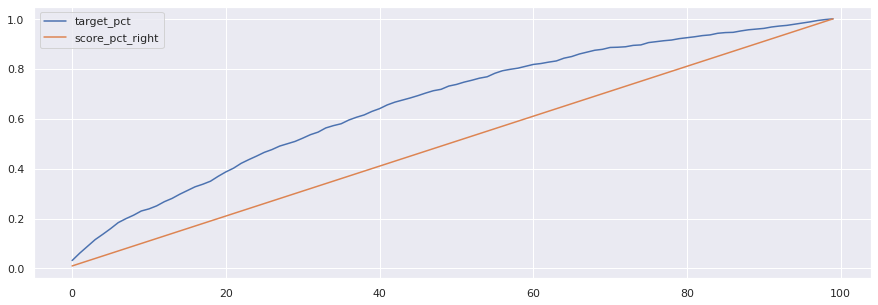

In [169]:
lift.plot(y=['target_pct', 'score_pct_right'], figsize=(15,5))